In [ ]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import json
import requests

# conda install -c conda-forge geopy --yes 
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# install the Geocoder
#!pip -q install geocoder
import geocoder

import time

# !conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('...Done')

In [7]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'

<Response [200]>

In [8]:
# Cleans html file
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')

# This extracts the "tbody" within the table where class is "wikitable sortable"
table = soup.find('table', {'class':'wikitable sortable'}).tbody

In [9]:
# Extracts all "tr" (table rows) within the table above
rows = table.find_all('tr')

In [10]:
# Extracts the column headers, removes and replaces possible '\n' with space for the "th" tag
columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]

In [11]:
# Converts columns to pd dataframe
df = pd.DataFrame(columns = columns)
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref


In [12]:
# Extracts every row with corresponding columns
# Then appends the values to the create pd dataframe "df"
# Please note that the first row (row[0]) is skipped because it is already the header
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')), tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')), tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        
        df = df.append(pd.Series(values, index = columns), ignore_index = True)

        df

In [13]:
df.head(5)

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [1]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[2]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[2],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[2],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [14]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London\xa0borough': 'Borough', 'Post town': 'Post-town', 'Postcode\xa0district': 'Postcode', 'Dial\xa0code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [15]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [1]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[2]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[2],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[2],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Looking the data, under the Borough, there are borough names with []. These are references extracted from the wiki page. So remove these, the following was done:

In [16]:
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [18]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


_Assumption 1:_ Where the Postcode are more than one, (for example, in Acton, there are 2 postcodes - W3 and W4), the postcodes are spread to multi-rows and assigned the same values from the other columns.

In [19]:
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [20]:
df0.head()

,Location,Borough,Post-town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


In [21]:
df0.shape

(638, 6)

As we have seen above, there are separate rows for Postcodes- W3 and W4.

_Assumption 2:_ From the data, only the 'LOcation','Borough',"Postcode' and 'Post-town' will be used for further analysis.

In [23]:
df1 = df0[['Location','Borough','Postcode','Post-town']].reset_index(drop=True)

In [24]:
df1.head()

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [25]:
df1.shape

(638, 4)

In [27]:
df2 = df1
df2 = df2[df2['Post-town'].str.contains('LONDON')]

In [29]:
df2.shape

(380, 4)

_Assumption 3:_ We have now 380 instances, (after removing non-London Post-town)

In [31]:
df3 = df2[['Location','Borough','Postcode']].reset_index(drop=True)

In [32]:
df3.head()

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


_Assumption 4_: This assumption will focus on the demography of London where there are predominantly more multicultural groups. According to the proportion of races by London borough as seen in  <a href="http://www.yahoo.com">Demography of London</a>
, the top 10 Asians are shown below:

In [58]:
df4 = pd.read_csv('London_asian.csv')

In [59]:
df4

,Local Authority,Asian
0,Newham,43.5
1,Harrow,42.6
2,Rebridge,41.8
3,Tower Hamels,41.1
4,Hounslow,34.4
5,Brent,34.1
6,Ealing,29.7
7,Hilington,25.3
8,Waltham Forest,21.1
9,Barnet,18.5


In [80]:
df_indian_top = df3[df3['Borough'].isin(['Newham','Harrow','Rebridge','Tower Hamels','Hounslow','Brent','Ealing','Hilington','Waltham Forest','Barnet'])].reset_index(drop = True)

In [81]:
df_indian_top.head()

,Location,Borough,Postcode
0,Church End,Brent,NW10
1,Church End,Barnet,N3
2,Colindale,Barnet,NW9
3,Colney Hatch,Barnet,N11
4,Colney Hatch,Barnet,N10


In [82]:
df_indian_top.shape

(80, 3)

#### In obtaining the location data of the locations, the Geocoder package is used with the arcgis_geocoder to obtain the latitude and longitude of the needed locations.

These will help to create a new dataframe that will be used subsequently for the South East London areas.

In [83]:
# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

In [84]:
sample = get_latlng('NW10')
sample

[51.53916000000004, -0.2512299999999641]

So, we are certain that the geocoder works fine. So we proceed to applying it to our dataframe df_asian_top.

In [77]:
start = time.time()

postal_codes = df_indian_top['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  127.5549087524414 seconds


In [85]:
df_indian_loc = df_asian_top

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_indian_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_indian_loc['Latitude'] = df_indian_coordinates['Latitude']
df_indian_loc['Longitude'] = df_indian_coordinates['Longitude']

In [93]:
df_indian_loc.head(30)

,Location,Borough,Postcode,Latitude,Longitude
0,Church End,Brent,NW10,51.539160,-0.25123
1,Church End,Barnet,N3,51.601040,-0.19401
2,Colindale,Barnet,NW9,51.584860,-0.24881
3,Colney Hatch,Barnet,N11,51.616310,-0.13841
4,Colney Hatch,Barnet,N10,51.591070,-0.14852
5,Custom House,Newham,E16,51.509130,0.01528
6,Dollis Hill,Brent,NW2,51.562370,-0.22131
7,Arkley,Barnet,EN5,51.644425,-0.17917
8,Arkley,Barnet,NW7,51.615680,-0.24511
9,Ealing,Ealing,W5,51.514060,-0.30073


In [89]:
df_indian_loc.to_csv('IndiaLondonLocationsCoordinates.csv', index = False)

In [91]:
df_indian_loc.shape

(80, 5)

The Foursquare API will be used to obtain the South East London Area venues for the geographical location data . These will be used to explore the neighbourhoods of London acordingly.

The venues within the neighbourhoods of London like the areas's restaurants and proximity to amenities would be correlated. Also, accessibility and ease of supplies would be considered as it relates to venues.

To use the Foursquare API, we define the Foursquare Credentials and Version as shown below:

In [92]:
#FourSquare Credentials
CLIENT_ID = 'KN0SRH2RHZ3HJRVQSH1BOQHLJ4ESYWSIC53QYCFXRQJSA5UW' # your Foursquare ID
CLIENT_SECRET = 'HBAAOTNXALQYM4JSCEJ1E2H4D3NXRNWGFU3IZG21UIDJIBHI' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KN0SRH2RHZ3HJRVQSH1BOQHLJ4ESYWSIC53QYCFXRQJSA5UW
CLIENT_SECRET:HBAAOTNXALQYM4JSCEJ1E2H4D3NXRNWGFU3IZG21UIDJIBHI


# 3. METHODOLOGY

## Exploring The Data

## 3.1 _For a Single Neighborhood_

An initial exploration of a single Neighbourhood within the London area was done to examine the Foursquare workability. The Hale Borough postcode NW17 and Location - The Hale is used for this.

In [95]:
df_indian_loc.loc[df_indian_loc['Location'] == 'The Hale']

,Location,Borough,Postcode,Latitude,Longitude
22,The Hale,Barnet,NW7,51.61568,-0.24511


In [96]:
hale_lat = df_indian_loc.loc[22,'Latitude']
hale_long = df_indian_loc.loc[22,'Longitude']
hale_loc = df_indian_loc.loc[22,'Location']
hale_postcode = df_indian_loc.loc[22,'Postcode']

print('The latitude and longitude values of {} with postcode {}, are {}, {}.'.format(hale_loc,
                                                                                         hale_postcode,
                                                                                         hale_lat,
                                                                                         hale_long))

The latitude and longitude values of The Hale with postcode NW7, are 51.615680000000054, -0.2451099999999542.


Let's explore the top 100 venues that are within a 2000 metres radius of _THE HALE_



In [98]:
# Credentials are provided already for this part
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    hale_lat, 
    hale_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=KN0SRH2RHZ3HJRVQSH1BOQHLJ4ESYWSIC53QYCFXRQJSA5UW&client_secret=HBAAOTNXALQYM4JSCEJ1E2H4D3NXRNWGFU3IZG21UIDJIBHI&v=20180604&ll=51.615680000000054,-0.2451099999999542&radius=2000&limit=100'

Then, send the GET request and examine the results.

In [99]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d0f64e989b06a002cb15826'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Mill Hill',
  'headerFullLocation': 'Mill Hill, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 36,
  'suggestedBounds': {'ne': {'lat': 51.63368001800007,
    'lng': -0.21617547462257447},
   'sw': {'lat': 51.59767998200004, 'lng': -0.2740445253773339}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4beee8ed3686c9b6122e256e',
       'name': 'The Good Earth',
       'location': {'lat': 51.61696051473806,
        'lng': -0.24528202455772874,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.61696051473806,
          'lng': -0.2

From the __results__, the necessary information needs to be obtained from items key. To do this, the _get__category__type_  function is used from the Foursquare lab.

In [100]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [101]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [102]:
nearby_venues

,name,categories,lat,lng
0,The Good Earth,Chinese Restaurant,51.616961,-0.245282
1,Bluebelles of Portabello,Café,51.614848,-0.246753
2,Powerleague,Soccer Field,51.607654,-0.226663
3,Mill Hill Golf Club,Golf Course,51.627944,-0.253174
4,RAF Museum London,History Museum,51.598521,-0.238738
5,Laboratory Spa & Health Club,Spa,51.598752,-0.235616
6,ShakeTastic Mill Hill,Juice Bar,51.613477,-0.250279
7,Mill Hill Park,Park,51.614895,-0.239139
8,M&S Foodhall,Grocery Store,51.614031,-0.249109
9,Burnt Oak Leisure Centre,Gym,51.605126,-0.255496


In [103]:
nearby_venues_hale_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [106]:
nearby_venues_hale_unique.head()

,Count
Grocery Store,3
Italian Restaurant,3
Golf Course,2
Pub,2
Hotel,2


Interestingly, even though there are Indian restaurants in the Hale area, they are not even in the top 5 venues. It should be noted that since we are limited by data availability, our perspectives will be on what we have.

In [107]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

36 venues were returned by Foursquare.


# 3.2 _For Multiple Neighborhoods_

To do this, the function getNearbyVenues is used and it's created to repeat the same process for all neighborhoods.

In [108]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [110]:
venues = getNearbyVenues(names=df_indian_loc['Location'],
                                   latitudes=df_indian_loc['Latitude'],
                                   longitudes=df_indian_loc['Longitude']
                                  )

Church End
Church End
Colindale
Colney Hatch
Colney Hatch
Custom House
Dollis Hill
Arkley
Arkley
Ealing
Ealing
East Finchley
East Ham
Finchley
Finchley
Finchley
Forest Gate
Friern Barnet
Golders Green
Grahame Park
Grove Park
Gunnersbury
The Hale
Hampstead Garden Suburb
Hanwell
Harlesden
Hendon
Highams Park
Barnet Gate
Barnet Gate
The Hyde
Kensal Green
Kensal Green
Kingsbury
Leyton
Leyton
Leytonstone
Little Ilford
Manor Park
Beckton
Beckton
Beckton
Maryland
Mill Hill
Neasden
Neasden
New Southgate
North Finchley
Bedford Park
North Woolwich
Oakleigh Park
Osidge
Plaistow
Queen's Park
Silvertown
Stonebridge
Stratford
Totteridge
Upper Walthamstow
Upton Park
Upton Park
Walthamstow
Walthamstow Village
West Ealing
West Ham
West Ham
West Hendon
Whetstone
Willesden
Woodside Park
Brent Cross
Brent Cross
Brent Park
Brondesbury
Brunswick Park
Burroughs, The
Cann Hall
Canning Town
Childs Hill
Chingford


In [111]:
len(venues)

6839

In [113]:
venues['Neighbourhood'].value_counts()
venues.to_csv('venues.csv')

In [114]:
venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Church End,51.53916,-0.25123,Beit El Zaytoun,51.534330,-0.261639,Middle Eastern Restaurant
1,Church End,51.53916,-0.25123,Rubio,51.537217,-0.241696,Pizza Place
2,Church End,51.53916,-0.25123,Centro Galego,51.532234,-0.236863,Spanish Restaurant
3,Church End,51.53916,-0.25123,Grand Junction Arms,51.534325,-0.260390,Pub
4,Church End,51.53916,-0.25123,Al Enam,51.526263,-0.258367,Middle Eastern Restaurant


The number of venues returned for each neighbourhoods is then explored as follows:

In [115]:
venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Arkley,97,97,97,97,97,97
Barnet Gate,97,97,97,97,97,97
Beckton,240,240,240,240,240,240
Bedford Park,100,100,100,100,100,100
Brent Cross,200,200,200,200,200,200
Brent Park,83,83,83,83,83,83
Brondesbury,100,100,100,100,100,100
Brunswick Park,84,84,84,84,84,84
"Burroughs, The",100,100,100,100,100,100


The next step is to check how many unique categories can be returned for the venues. See as follows:

In [118]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 219 uniques categories.


In [120]:
venue_unique_count = venues['Venue Category'].value_counts().to_frame(name='Count')

In [126]:
venue_unique_count.head(12)

,Count
Pub,540
Coffee Shop,508
Grocery Store,408
Café,353
Park,274
Hotel,255
Supermarket,212
Pizza Place,200
Fast Food Restaurant,158
Italian Restaurant,153


In [132]:
venue_unique_count.describe()

,Count
count,219.000000
mean,31.228311
std,70.864018
min,1.000000
25%,4.000000
50%,10.000000
75%,23.500000
max,540.000000


# CLUSTERING

For this section, the promising neighbourhoods in London will be clustered based on the processed data obtained above.

In [133]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [141]:
# df_london_map
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

The Selected London neighbourhoods are then superimposed on top as shown below, still using the foliumlibrary. Please note due to the location of the Loondon, you might need to zoom to see the superimposed areas

In [142]:
# Adding markers to map
for lat, lng, borough, loc in zip(df_indian_loc['Latitude'], 
                                  df_indian_loc['Longitude'],
                                  df_indian_loc['Borough'],
                                  df_indian_loc['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

__ANALYSING EACH NEIGHBORHOOD__

In this section, the objective is to check and explore the venues in each neighbourhood.

In [143]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix = "", prefix_sep = "")

Then the Neighbourhoodcolumn is added back to the dataframe.

In [147]:
# add neighborhood column back to the dataframe

onehot['Neighbourhood'] = venues['Neighbourhood']

In [148]:
onehot.head()

,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Canal Lock,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Costume Shop,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Flea Market,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Historic Site,History Museum,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Rafting,Ramen Restaurant,Recording Studio,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Restaurant,Rugby Pitch,Rugby Stadium,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Church End
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [149]:
# Move NEIGHBOURHOOD column to the starting column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])

onehot = onehot[fixed_columns]

In [150]:
onehot.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Canal Lock,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Costume Shop,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Flea Market,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Historic Site,History Museum,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Rafting,Ramen Restaurant,Recording Studio,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Restaurant,Rugby Pitch,Rugby Stadium,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Church End,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Church End,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [151]:
onehot.loc[onehot['Indian Restaurant'] != 0]

,Neighbourhood,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Canal Lock,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Costume Shop,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Flea Market,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Historic Site,History Museum,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Rafting,Ramen Restaurant,Recording Studio,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Restaurant,Rugby Pitch,Rugby Stadium,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
15,Church End,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31,Church End,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [152]:
onehot.loc[onehot['Neighbourhood'] == 'The Hale']

,Neighbourhood,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Canal Lock,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Costume Shop,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Flea Market,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Historic Site,History Museum,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Rafting,Ramen Restaurant,Recording Studio,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Restaurant,Rugby Pitch,Rugby Stadium,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
1972,The Hale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1973,The Hale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

As can be seen from above, THE HALE with its demography has only 1 Indian Restaurant

In [153]:
onehot.to_csv('london_onehot.csv', index = False)

In [154]:
onehot.shape

(6839, 220)

In [155]:
grouped = onehot.groupby('Neighbourhood').mean().reset_index()
grouped.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Canal Lock,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Costume Shop,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Flea Market,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Historic Site,History Museum,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Rafting,Ramen Restaurant,Recording Studio,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Restaurant,Rugby Pitch,Rugby Stadium,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Arkley,0.000,0.000000,0.0,0.0,0.010309,0.000000,0.0,0.010309,0.010309,0.000,0.000,0.020619,0.000000,0.0,0.0,0.0,0.0,0.010309,0.0,0.00,0.0,0.000,0.0,0.000000,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.072165,0.0,0.0,0.0,0.0,0.010309,0.0,0.010309,0.092784,0.00,0.0,0.0,0.000,0.000,0.0,0.00,0.000,0.000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000,0.010309,0.00,0.010309,0.0,0.0,0.020619,0.00,0.0,0.0,0.000,0.010309,0.00,0.020619,0.0,0.000000,0.0,0.00,0.0000,0.010309,0.0,0.000,0.00,0.030928,0.000000,0.0,0.010309,0.092784,0.020619,0.000000,0.010309,0.000,0.000000,0.00,0.010309,0.0,0.0,0.00,0.030928,0.000000,0.000000,0.030928,0.0,0.0,0.000,0.000,0.061856,0.000,0.010309,0.000,0.000,0.000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0000,0.0,0.000000,0.000000,0.010309,0.0,0.000000,0.0,0.00,0.0,0.0

In [156]:
print("Before One-hot encoding:",df_indian_loc.shape)
print("After One-hot encoding:", grouped.shape)

Before One-hot encoding: (80, 5)
After One-hot encoding: (65, 220)


In [157]:
grouped.to_csv('london_grouped.csv', index = False)

Grouping of each Neighbourhoods with 10 common venues:

In [159]:
num_top_venues = 10 # Top common venues needed

for hood in grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Arkley----
                venue  freq
0       Grocery Store  0.09
1                 Pub  0.09
2         Coffee Shop  0.09
3                Café  0.07
4  Italian Restaurant  0.06
5                Park  0.04
6         Pizza Place  0.03
7               Hotel  0.03
8   Indian Restaurant  0.03
9         Golf Course  0.03


----Barnet Gate----
                venue  freq
0       Grocery Store  0.09
1                 Pub  0.09
2         Coffee Shop  0.09
3                Café  0.07
4  Italian Restaurant  0.06
5                Park  0.04
6         Pizza Place  0.03
7               Hotel  0.03
8   Indian Restaurant  0.03
9         Golf Course  0.03


----Beckton----
                  venue  freq
0                 Hotel  0.11
1         Grocery Store  0.08
2           Coffee Shop  0.07
3                   Pub  0.05
4        Sandwich Place  0.04
5           Supermarket  0.04
6  Fast Food Restaurant  0.04
7     Indian Restaurant  0.03
8                  Park  0.03
9    Chinese Restaurant  0.02

                       venue  freq
0                Coffee Shop  0.08
1              Grocery Store  0.07
2                        Pub  0.06
3                Pizza Place  0.06
4  Middle Eastern Restaurant  0.05
5       Fast Food Restaurant  0.04
6                Supermarket  0.04
7             Sandwich Place  0.04
8              Movie Theater  0.04
9                      Hotel  0.04


----Hendon----
                  venue  freq
0           Coffee Shop  0.11
1         Grocery Store  0.08
2                  Café  0.05
3  Gym / Fitness Center  0.05
4                 Hotel  0.04
5           Pizza Place  0.04
6                   Pub  0.04
7           Supermarket  0.04
8      Department Store  0.03
9                  Park  0.03


----Highams Park----
                    venue  freq
0                     Pub  0.12
1           Grocery Store  0.09
2                    Park  0.07
3             Coffee Shop  0.07
4             Supermarket  0.05
5      Golf Driving Range  0.04
6      Turkish Restau

                  venue  freq
0                   Pub  0.12
1         Grocery Store  0.08
2           Coffee Shop  0.06
3           Supermarket  0.06
4           Pizza Place  0.05
5                  Café  0.04
6            Restaurant  0.03
7  Gym / Fitness Center  0.03
8               Brewery  0.03
9    Turkish Restaurant  0.02


----Upton Park----
                  venue  freq
0         Grocery Store  0.11
1           Coffee Shop  0.07
2                   Pub  0.06
3  Fast Food Restaurant  0.06
4     Indian Restaurant  0.05
5                 Hotel  0.05
6                  Park  0.05
7                Bakery  0.03
8              Platform  0.03
9                  Café  0.03


----Walthamstow----
                  venue  freq
0                   Pub  0.12
1         Grocery Store  0.08
2           Coffee Shop  0.06
3           Supermarket  0.06
4           Pizza Place  0.05
5                  Café  0.04
6            Restaurant  0.03
7  Gym / Fitness Center  0.03
8               Brewery  0.

__Creating new dataframe:__
Putting the common venues into pandas dataframe, the following return_most_common_venuesis used to sort the venues in descending order.

In [160]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Then we create a new panda dataframe with 10 most common venues as shown below:

In [165]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = grouped['Neighbourhood']

for ind in np.arange(grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

In [166]:
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arkley,Coffee Shop,Grocery Store,Pub,Café,Italian Restaurant,Park,Indian Restaurant,Hotel,Pharmacy,Golf Course
1,Barnet Gate,Coffee Shop,Grocery Store,Pub,Café,Italian Restaurant,Park,Indian Restaurant,Hotel,Pharmacy,Golf Course
2,Beckton,Hotel,Grocery Store,Coffee Shop,Pub,Fast Food Restaurant,Supermarket,Sandwich Place,Park,Indian Restaurant,Pizza Place
3,Bedford Park,Pub,Coffee Shop,Park,Bakery,Thai Restaurant,Café,Gym / Fitness Center,Hotel,French Restaurant,Restaurant
4,Brent Cross,Coffee Shop,Grocery Store,Café,Pub,Supermarket,Hotel,Park,Gym / Fitness Center,Pizza Place,Department Store


In [167]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [169]:
grouped_clustering = grouped.drop('Neighbourhood', 1)

## Clustering of Neighbourhoods

The next thing to do now, is to create clusters of the neighbourhood using the k-means to cluster the neighbourhood into 5 clusters.

In [171]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 3, 4, 1, 1, 4, 0, 1, 0])

In [172]:
kmeans.labels_[0:10]

array([0, 0, 3, 4, 1, 1, 4, 0, 1, 0])

Now creating a new dataframe that includes the clusters as well as the top 10 venues for each neighbourhoods.

In [202]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [203]:
merged = df_indian_loc

In [204]:
merged.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Church End,Brent,NW10,51.53916,-0.25123
1,Church End,Barnet,N3,51.60104,-0.19401
2,Colindale,Barnet,NW9,51.58486,-0.24881
3,Colney Hatch,Barnet,N11,51.61631,-0.13841
4,Colney Hatch,Barnet,N10,51.59107,-0.14852


In [205]:
# match/merge SE London data with latitude/longitude for each neighborhood
merged_latlong = merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [206]:
merged_latlong.head(5)

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Church End,Brent,NW10,51.53916,-0.25123,1,Grocery Store,Coffee Shop,Supermarket,Pub,Pizza Place,Bakery,Middle Eastern Restaurant,Café,Park,Fast Food Restaurant
1,Church End,Barnet,N3,51.60104,-0.19401,1,Grocery Store,Coffee Shop,Supermarket,Pub,Pizza Place,Bakery,Middle Eastern Restaurant,Café,Park,Fast Food Restaurant
2,Colindale,Barnet,NW9,51.58486,-0.24881,1,Coffee Shop,Café,Pub,Park,Gym / Fitness Center,Grocery Store,Supermarket,Pizza Place,Sandwich Place,Asian Restaurant
3,Colney Hatch,Barnet,N11,51.61631,-0.13841,0,Pub,Café,Coffee Shop,Grocery Store,Park,Pizza Place,Greek Restaurant,Indian Restaurant,Italian Restaurant,Supermarket
4,Colney Hatch,Barnet,N10,51.59107,-0.14852,0,Pub,Café,Coffee Shop,Grocery Store,Park,Pizza Place,Greek Restaurant,Indian Restaurant,Italian Restaurant,Supermarket


In [207]:
clusters = merged_latlong

Number clusters = 5, is chosen for initial run

To get the optimal number of clusters to be used for the K-mean, there are a number ways possible for the evaluation. Therefore, in this task, the following are used:

__1. ELBOW METHOD__
The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.

The approach for this is to run the k-means clustering for a range of value k and for each value of k, the Sum of the Squared Errors (SSE) is calculated., calculate sum of squared errors (SSE). When this is done, a plot of k and the corresponding SSEs are then made. At the elbow (just like arm), that is where the optimal value of k is. And that will be the number of clusters to be used. The whole idea is to have minimum SSE.

In [208]:
%matplotlib inline
import matplotlib
import numpy as np

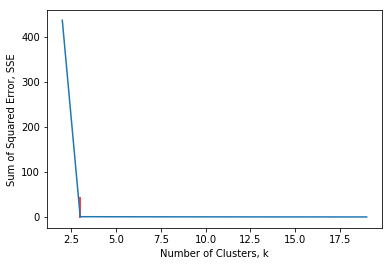

In [210]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2,20):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(grouped_clustering)
    grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

Depending on the number of iteration (in this case, 500 iterations were used), the number of cluster, k is 3.

__2. SILHOUTE COEFFICIENT__
To find the optimal value of the number of clusters, k, the number of clusters is iterated corresponding Silhouette Coefficientis calculated for each of the k-values used. The highest Silhouette Coefficient gives the best match to its own cluster. Please see below:

In [215]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2,7):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.5989578801789757
Where n_clusters = 3, the Silhouette Coefficient is 0.5935115758275363
Where n_clusters = 4, the Silhouette Coefficient is 0.5897286264071737
Where n_clusters = 5, the Silhouette Coefficient is 0.5903808182884813
Where n_clusters = 6, the Silhouette Coefficient is 0.6042348338634029


In [216]:
clusters.columns

Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [217]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clusters['Latitude'], clusters['Longitude'], clusters['Location'], clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

__CLUSTER 1__

In [219]:
clusters.loc[clusters['Cluster Labels'] == 0, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Barnet,0,Pub,Café,Coffee Shop,Grocery Store,Park,Pizza Place,Greek Restaurant,Indian Restaurant,Italian Restaurant,Supermarket
4,Barnet,0,Pub,Café,Coffee Shop,Grocery Store,Park,Pizza Place,Greek Restaurant,Indian Restaurant,Italian Restaurant,Supermarket
7,Barnet,0,Coffee Shop,Grocery Store,Pub,Café,Italian Restaurant,Park,Indian Restaurant,Hotel,Pharmacy,Golf Course
8,Barnet,0,Coffee Shop,Grocery Store,Pub,Café,Italian Restaurant,Park,Indian Restaurant,Hotel,Pharmacy,Golf Course
11,Barnet,0,Café,Pub,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Forest,Pizza Place,Grocery Store,Indian Restaurant,Greek Restaurant
17,Barnet,0,Pub,Grocery Store,Coffee Shop,Café,Park,Pizza Place,Fast Food Restaurant,Greek Restaurant,Supermarket,Bus Stop
23,Barnet,0,Café,Pub,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Forest,Pizza Place,Grocery Store,Indian Restaurant,Greek Restaurant
27,Waltham Forest,0,Pub,Grocery Store,Park,Coffee Shop,Supermarket,Furniture / Home Store,Gym,Sporting Goods Shop,Turkish Restaurant,Golf Driving Range
28,Barnet,0,Coffee Shop,Grocery Store,Pub,Café,Italian Restaurant,Park,Indian Restaurant,Hotel,Pharmacy,Golf Course
29,Barnet,0,Coffee Shop,Grocery Store,Pub,Café,Italian Restaurant,Park,Indian Restaurant,Hotel,Pharmacy,Golf Course


In [220]:
clusters.loc[clusters['Cluster Labels'] == 1, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brent,1,Grocery Store,Coffee Shop,Supermarket,Pub,Pizza Place,Bakery,Middle Eastern Restaurant,Café,Park,Fast Food Restaurant
1,Barnet,1,Grocery Store,Coffee Shop,Supermarket,Pub,Pizza Place,Bakery,Middle Eastern Restaurant,Café,Park,Fast Food Restaurant
2,Barnet,1,Coffee Shop,Café,Pub,Park,Gym / Fitness Center,Grocery Store,Supermarket,Pizza Place,Sandwich Place,Asian Restaurant
6,Brent,1,Coffee Shop,Grocery Store,Pub,Café,Supermarket,Park,Italian Restaurant,Hotel,Clothing Store,Korean Restaurant
13,Barnet,1,Café,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Supermarket,Gym / Fitness Center,Turkish Restaurant,Bakery,Pizza Place
14,Barnet,1,Café,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Supermarket,Gym / Fitness Center,Turkish Restaurant,Bakery,Pizza Place
15,Barnet,1,Café,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Supermarket,Gym / Fitness Center,Turkish Restaurant,Bakery,Pizza Place
18,Barnet,1,Coffee Shop,Grocery Store,Café,Bakery,Park,Hotel,Supermarket,Korean Restaurant,Sushi Restaurant,Pub
19,Barnet,1,Coffee Shop,Café,Pub,Park,Gym / Fitness Center,Grocery Store,Supermarket,Pizza Place,Sandwich Place,Asian Restaurant
25,Brent,1,Coffee Shop,Grocery Store,Pizza Place,Pub,Middle Eastern Restaurant,Fast Food Restaurant,Supermarket,Hotel,Movie Theater,Lebanese Restaurant


In [221]:
clusters.loc[clusters['Cluster Labels'] == 2, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Newham,2,Hotel,Coffee Shop,Pub,Grocery Store,Chinese Restaurant,Bar,Lounge,Sandwich Place,Park,Burger Joint
49,Newham,2,Hotel,Coffee Shop,Pub,Grocery Store,Chinese Restaurant,Bar,Lounge,Sandwich Place,Park,Burger Joint
54,Newham,2,Hotel,Coffee Shop,Pub,Grocery Store,Chinese Restaurant,Bar,Lounge,Sandwich Place,Park,Burger Joint
77,Newham,2,Hotel,Coffee Shop,Pub,Grocery Store,Chinese Restaurant,Bar,Lounge,Sandwich Place,Park,Burger Joint


In [222]:
clusters.loc[clusters['Cluster Labels'] == 3, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Newham,3,Grocery Store,Indian Restaurant,Hotel,Coffee Shop,Supermarket,Fast Food Restaurant,Pub,Furniture / Home Store,Sandwich Place,Pizza Place
16,Newham,3,Pub,Grocery Store,Indian Restaurant,Park,Café,Fast Food Restaurant,Bakery,Metro Station,Restaurant,Coffee Shop
22,Barnet,3,Italian Restaurant,Grocery Store,Pub,Golf Course,Hotel,Fast Food Restaurant,Farm,Park,Fried Chicken Joint,Coffee Shop
37,Newham,3,Grocery Store,Indian Restaurant,Fast Food Restaurant,Pub,Clothing Store,Hotel,Bakery,Coffee Shop,Supermarket,Sandwich Place
38,Newham,3,Grocery Store,Indian Restaurant,Fast Food Restaurant,Pub,Clothing Store,Hotel,Bakery,Coffee Shop,Supermarket,Sandwich Place
39,Newham,3,Hotel,Grocery Store,Coffee Shop,Pub,Fast Food Restaurant,Supermarket,Sandwich Place,Park,Indian Restaurant,Pizza Place
40,Newham,3,Hotel,Grocery Store,Coffee Shop,Pub,Fast Food Restaurant,Supermarket,Sandwich Place,Park,Indian Restaurant,Pizza Place
41,Newham,3,Hotel,Grocery Store,Coffee Shop,Pub,Fast Food Restaurant,Supermarket,Sandwich Place,Park,Indian Restaurant,Pizza Place
43,Barnet,3,Italian Restaurant,Grocery Store,Pub,Golf Course,Hotel,Fast Food Restaurant,Farm,Park,Fried Chicken Joint,Coffee Shop
52,Newham,3,Grocery Store,Park,Coffee Shop,Fast Food Restaurant,Pub,Platform,Café,Gym / Fitness Center,Bakery,Turkish Restaurant


In [226]:
clusters.loc[clusters['Cluster Labels'] == 4, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Ealing,4,Pub,Coffee Shop,Park,Café,Italian Restaurant,Hotel,Pizza Place,Gym / Fitness Center,Burger Joint,Vietnamese Restaurant
10,Ealing,4,Pub,Coffee Shop,Park,Café,Italian Restaurant,Hotel,Pizza Place,Gym / Fitness Center,Burger Joint,Vietnamese Restaurant
20,Hounslow,4,Pub,Coffee Shop,Park,Bakery,Thai Restaurant,Café,Gym / Fitness Center,Hotel,French Restaurant,Restaurant
21,Hounslow,4,Pub,Coffee Shop,Park,Bakery,Thai Restaurant,Café,Gym / Fitness Center,Hotel,French Restaurant,Restaurant
24,Ealing,4,Park,Pub,Grocery Store,Hotel,Persian Restaurant,Indian Restaurant,Supermarket,Gym,Café,Coffee Shop
31,Brent,4,Pub,Coffee Shop,Pizza Place,Grocery Store,Café,Bakery,Middle Eastern Restaurant,Supermarket,Indian Restaurant,Thai Restaurant
32,Brent,4,Pub,Coffee Shop,Pizza Place,Grocery Store,Café,Bakery,Middle Eastern Restaurant,Supermarket,Indian Restaurant,Thai Restaurant
34,Waltham Forest,4,Pub,Café,Park,Bar,Coffee Shop,Hotel,Sandwich Place,Grocery Store,Italian Restaurant,Clothing Store
35,Waltham Forest,4,Pub,Café,Park,Bar,Coffee Shop,Hotel,Sandwich Place,Grocery Store,Italian Restaurant,Clothing Store
42,Newham,4,Café,Pub,Bar,Park,Nightclub,Grocery Store,Hotel,Art Gallery,Coffee Shop,Italian Restaurant


# 4. RESULT

__HIGHLIGHTS FROM ABOVE 5 CLUSTERS__

1. Pubs, Cafe, Coffee Shops are popular in the London.
2. As for restaurants, the Italian Restaurants are very popular in the  London. Especially in Southwark and Lambeth areas.
3. Although, the Clusters have variations, a very visible presence is the predominance of pubs.

_We conclude from above observation that CLUSTERS 2 and 4 are scarce in terms of availability of INDIAN RESTAURANTS_

Hence, above two mentioned clusters are suitable for opening a new INDIAN RESTAURANT

# 5. DISCUSSION AND CONCLUSION

It is very important to note that Clusters 2 and 3 are the most viable clusters to create a __INDIAN RESTAURANT__. Their proximity to other amenities and accessibility to INDIAN PEOPLE are paramount. These 2 _clusters do not have top restaurants that could rival their standards_ if they are created. And the proximity to resources needed is paramount.

In conclusion, this project would have had better results if there were more data in terms of crime data within the area, traffic access and allowance of more venues exploration with the Foursquare (limited venues for free calls).

Also, getting the ratings and feedbacks of the current restaurants within the clusters would have helped in providing more insight into the best location.